# Import du set de training

Dans cette premiere partie, le set de training est importé depuis mes fichiers locaux. Le path des NORMAL et PNEUMONIA est set up. En dessous, un example d'extrait d'une image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

DATADIR = 'chest_Xray/train'
CATEGORIES = ['NORMAL', 'PNEUMONIA']

# Debut de l'algorithme du model

Set up d'un model basé sur 5 convolutions, en doublant a chaque convolution le nombre de noeuds.

Deux set sont créé: 

- le trainig set basé sur le dossier train
- le validation set basé sur le set de validation

Les données de sont divisées pour se retrouver entre 0 et 1 (plus simple pour classsifié que entre 0 et 255)


Sachant que la taille des images est resize a 300x300, nous avons decide de limiter le nombre de step par epochs a 10 afin que le programme ne prenne pas trop de temps à s'exécuter.

Le model est ensuite sauvegardé afin d'etre reutilisé dans d'autre fenetre Jupyter.

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential([
  
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
  
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])

test_datagen = ImageDataGenerator(rescale = 1/255)
train_datagen = ImageDataGenerator(rescale = 1/255)

validation_generator = test_datagen.flow_from_directory(
    'chest_Xray/val',
    target_size = (300, 300),
    batch_size = 128,
    class_mode = 'binary'
)

train_generator = train_datagen.flow_from_directory(
    'chest_Xray/train',
    target_size = (300,300),
    batch_size = 128,
    class_mode = 'binary'
)
            
history = model.fit(train_generator, steps_per_epoch = 20, epochs = 10, validation_data = validation_generator, class_weight = { 0 : 1.94 , 1 : 0.67 })

model.save('normal-pneumonia.model')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Found 16 images belonging to 2 classes.


/home/basile/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Found 5216 images belonging to 2 classes.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
10/10 [==============================] - 28s 3s/step - loss: 0.7826 - accuracy: 0.5060 - val_loss: 2.4518 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 27s 3s/step - loss: 1.2214 - accuracy: 0.6194 - val_loss: 0.5527 - val_accuracy: 0.6250
Epoch 3/10
10/10 [==============================] - 27s 3s/step - loss: 0.4346 - accuracy: 0.8208 - val_loss: 0.4531 - val_accuracy: 0.8125
Epoch 4/10
10/10 [==============================] - 27s 3s/step - loss: 1.3208 - accuracy: 0.8366 - val_loss: 0.5205 - val_accuracy: 0.6250
Epoch 5/10
10/10 [==============================] - 27s 3s/step - loss: 0.3887 - accuracy: 0.8641 - val_loss: 0.5193 - val_accuracy: 0.6250
Epoch 6/10
10/10 [==============================] - 28s 3s/step - loss: 0.3207 - accuracy: 0.8790 - val_loss: 0.3342 - v

# Test and metrics

La premiere metric qui peut être regardée est l'accuracy et la loss du model que ce soit par le training set ou le validation set.

La deuxieme partie sert a avoir un resumé de la compilation du model.

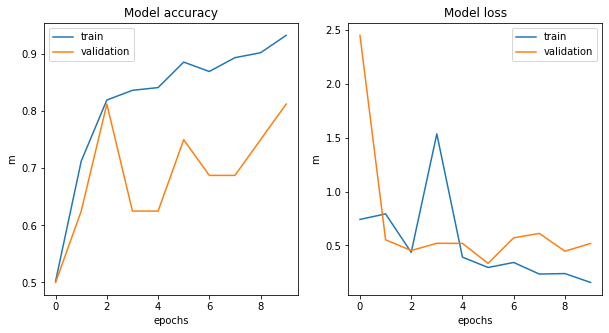

In [3]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

metric = ['accuracy', 'loss']
for i, m in enumerate(metric):
  ax[i].plot(history.history[m])
  ax[i].plot(history.history['val_'+ m])
  ax[i].set_title('Model {}'.format(m))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel('m')
  ax[i].legend(['train', 'validation'])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       7

# Test the result

Cette partie est utilisée pour checker la véracitée du model. Pour cela nous avons fait premierement une fonction comparant les vrai resultats par rapport a ceux obtenue. La facon la plus connue est l'utilisation d'une matrice de confusion. On peu ainsi voir avec plus de visibilité les differences entre les differents modeles à comparer.

Le deuxieme test est fait a partir de la fonciton tensorflow evaluate_generator qui va calculé le taux de reussite et le taux de failure du modele.

In [5]:
from keras.preprocessing import image

def prepare(filepath):
    img = image.load_img(full_path, target_size=(300,300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis =0)
    return x

In [7]:
path_pneumonia = "chest_Xray/test/PNEUMONIA"

path_normal = "chest_Xray/test/NORMAL"

failed_pneu = 0
success_pneu = 0
failed_nor = 0
success_nor = 0

for element in os.listdir(path_pneumonia):
    full_path = path_pneumonia + "//" + element
    if CATEGORIES[int(model.predict([prepare(full_path)]))] != "PNEUMONIA":
        failed_pneu = failed_pneu + 1
    else:
        success_pneu = success_pneu + 1

for element in os.listdir(path_normal):
    full_path = path_normal + "//" + element
    if CATEGORIES[int(model.predict([prepare(full_path)]))] != "NORMAL":
        failed_nor = failed_nor + 1
    else:
        success_nor = success_nor + 1

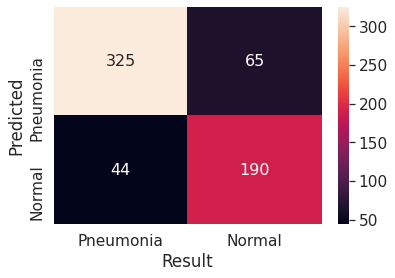

In [8]:
import seaborn as sn
import pandas as pd

array = [[success_pneu, failed_pneu],
         [failed_nor, success_nor]]

columns = ['Normal','Pneumonia']
index = ['Pneumonia', 'Normal']

df_cm = pd.DataFrame(array, index=index, columns=index)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

plt.ylabel('Predicted')
plt.xlabel('Result')
plt.show()

In [9]:
test_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = test_datagen.flow_from_directory(
    'chest_Xray/test',
    target_size = (300, 300),
    batch_size = 128, 
    class_mode = 'binary'
)

eval_result = model.evaluate_generator(test_generator, 10)
print('loss rate at evaluation data :', eval_result[0])
print('accuracy rate at evaluation data :', eval_result[1])

Found 624 images belonging to 2 classes.


/home/basile/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1978: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss rate at evaluation data : 0.3951590955257416
accuracy rate at evaluation data : 0.8125


# Bonus pneumonia detection

La premiere partie est utilisée pour créer des nouveau repertoire afin de stocker les futures images de pneumonie en se basant sur le fait que se soit des virus ou des bacterie (information située dans le nom du fichier).

Afin de se servir des données déjà existantes on a utilisé shutil qui permet de copier coller directement depuis le code python.

In [12]:
try:
    os.mkdir("chest_Xray/extra")
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")
    
try:
    os.mkdir("chest_Xray/extra/train")
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")
    
try:
    os.mkdir("chest_Xray/extra/test")
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")
    
try:
    os.mkdir("chest_Xray/extra/val")
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")
    
try:
    os.mkdir("chest_Xray/extra/train/BACTERIA")
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")

try:
    os.mkdir("chest_Xray/extra/train/VIRUS")
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")
    
try:
    os.mkdir("chest_Xray/extra/test/BACTERIA")
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")

try:
    os.mkdir("chest_Xray/extra/test/VIRUS")
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")
    
try:
    os.mkdir("chest_Xray/extra/val/BACTERIA")
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory ")

try:
    os.mkdir("chest_Xray/extra/val/VIRUS")
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")

Successfully created the directory
Successfully created the directory
Successfully created the directory
Successfully created the directory
Successfully created the directory
Successfully created the directory
Successfully created the directory
Successfully created the directory
Successfully created the directory 
Successfully created the directory


## Création du nouveau set de donnée se basant uniquement sur les données de pneumonie.

Pour cela on se base sur la nomenclature des noms de chaque photo (il est ecrit si c'est un virus ou une bacterie dans le nom).
Ensuite, on créer trois set, un de training, un de validation et un de test. 

Celui de validation a été agrandie de 8 photos par rapport au sujet de base afin d'ajouter des photos de virus (non existante de base dans le dossier de validation).

Tout ce nouveau set est enregistré dans un nouveau dossier "extra".

In [13]:
import shutil

DATADIR_PNEU_TRAIN = 'chest_Xray/train/PNEUMONIA'
CATEGORIES_PNEU = ['BACTERIA', 'VIRUS']

bacteria_array = []
virus_array = []

bacteria = 0
virus = 0

for category in CATEGORIES_PNEU:
    class_num = CATEGORIES_PNEU.index(category)
    for img in os.listdir(DATADIR_PNEU_TRAIN):
        if ("bacteria" in img and category == "BACTERIA"):
            img_array = cv2.imread(os.path.join(DATADIR_PNEU_TRAIN, img), cv2.IMREAD_GRAYSCALE)
            shutil.copy(os.path.join(DATADIR_PNEU_TRAIN, img), "chest_Xray/extra/train/BACTERIA")
            bacteria_array.append([img_array, class_num])
            bacteria = bacteria + 1
        elif ("virus" in img and category == "VIRUS"):
            img_array = cv2.imread(os.path.join(DATADIR_PNEU_TRAIN, img), cv2.IMREAD_GRAYSCALE)
            shutil.copy(os.path.join(DATADIR_PNEU_TRAIN, img), "chest_Xray/extra/train/VIRUS")
            virus_array.append([img_array, class_num])
            virus = virus + 1

In [14]:
DATADIR_PNEU_TEST = 'chest_Xray/test/PNEUMONIA'

bacteria = 0
virus = 0
i = 0
j = 0

for category in CATEGORIES_PNEU:
    class_num = CATEGORIES_PNEU.index(category)
    for img in os.listdir(DATADIR_PNEU_TEST):
        if ("bacteria" in img and category == "BACTERIA"):
            if i < 8:
                img_array = cv2.imread(os.path.join(DATADIR_PNEU_TEST, img), cv2.IMREAD_GRAYSCALE)
                shutil.copy(os.path.join(DATADIR_PNEU_TEST, img), "chest_Xray/extra/val/BACTERIA")
                bacteria_array.append([img_array, class_num])
                i = i + 1
            else:
                img_array = cv2.imread(os.path.join(DATADIR_PNEU_TEST, img), cv2.IMREAD_GRAYSCALE)
                shutil.copy(os.path.join(DATADIR_PNEU_TEST, img), "chest_Xray/extra/test/BACTERIA")
                bacteria_array.append([img_array, class_num])
                bacteria = bacteria + 1
        elif ("virus" in img and category == "VIRUS"):
            if j < 8:
                img_array = cv2.imread(os.path.join(DATADIR_PNEU_TEST, img), cv2.IMREAD_GRAYSCALE)
                shutil.copy(os.path.join(DATADIR_PNEU_TEST, img), "chest_Xray/extra/val/VIRUS")
                bacteria_array.append([img_array, class_num])
                j = j + 1
            else:
                img_array = cv2.imread(os.path.join(DATADIR_PNEU_TEST, img), cv2.IMREAD_GRAYSCALE)
                shutil.copy(os.path.join(DATADIR_PNEU_TEST, img), "chest_Xray/extra/test/VIRUS")
                virus_array.append([img_array, class_num])
                virus = virus + 1

# The second model

Le model est tres similaire au premier et se base sur deux set, un de training et un de validation (en se basant sur les dossier créés juste avant

In [15]:
model2 = tf.keras.models.Sequential([
  
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
  
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])

test_datagen2 = ImageDataGenerator(rescale = 1/255)
train_datagen2 = ImageDataGenerator(rescale = 1/255)

validation_generator2 = test_datagen2.flow_from_directory(
    'chest_Xray/extra/val',
    target_size = (300, 300),
    batch_size = 128,
    class_mode = 'binary'
)

train_generator2 = train_datagen2.flow_from_directory(
    'chest_Xray/extra/train',
    target_size = (300,300),
    batch_size = 128,
    class_mode = 'binary'
)
            
history2 = model2.fit(train_generator2, steps_per_epoch = 10, epochs = 10, validation_data = validation_generator2, class_weight = { 0 : 0.8 , 1 : 1.5 })

model2.save('virus-bacteria.model')

/home/basile/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Found 16 images belonging to 2 classes.
Found 3875 images belonging to 2 classes.
Epoch 1/10
10/10 [==============================] - 28s 3s/step - loss: 1.2504 - accuracy: 0.5484 - val_loss: 0.6504 - val_accuracy: 0.5625
Epoch 2/10
10/10 [==============================] - 28s 3s/step - loss: 1.3083 - accuracy: 0.5460 - val_loss: 0.5636 - val_accuracy: 0.8125
Epoch 3/10
10/10 [==============================] - 28s 3s/step - loss: 0.8554 - accuracy: 0.5809 - val_loss: 0.5276 - val_accuracy: 0.9375
Epoch 4/10
10/10 [==============================] - 28s 3s/step - loss: 0.6346 - accuracy: 0.7024 - val_loss: 0.2752 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 26s 3s/step - loss: 0.6326 - accuracy: 0.6839 - val_loss: 0.1858 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 28s 3s/step - loss: 0.5764 - accuracy: 0.7280 - val_loss: 0.2479 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 28s 3s/step - loss: 1.8790

## Metriques pour le bonus

Meme si le bonus n'a été fait que avec cet algorithme et n'a donc pas pour objectif d'etre comparé, il peut toujours etre utile de visualiser la veracité de ce modele numero 2.

In [16]:
path_bacteria = "chest_Xray/extra/test/BACTERIA"

path_virus = "chest_Xray/extra/test/VIRUS"

failed_vir = 0
failed_bac = 0
success_vir = 0
success_bac = 0

for element in os.listdir(path_bacteria):
    full_path = path_bacteria + "//" + element
    #print(CATEGORIES_PNEU[int(model2.predict([prepare(full_path)]))] + " " + element)
    if CATEGORIES_PNEU[int(model2.predict([prepare(full_path)]))] != "BACTERIA":
        failed_bac = failed_bac + 1
    else:
        success_bac = success_bac + 1

for element in os.listdir(path_virus):
    full_path = path_virus + "//" + element
    #print(CATEGORIES_PNEU[int(model2.predict([prepare(full_path)]))] + " " + element)
    if CATEGORIES_PNEU[int(model2.predict([prepare(full_path)]))] != "VIRUS":
        failed_vir = failed_vir + 1
    else:
        success_vir = success_vir + 1
        
print(failed_vir, failed_bac, success_vir, success_bac)

24 14 116 220


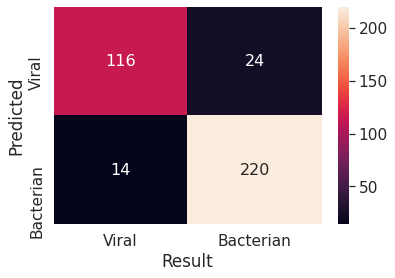

In [17]:
import seaborn as sn
import pandas as pd

array = [[success_vir, failed_vir],
         [failed_bac, success_bac]]

columns = ['Bacterian','Viral']
index = ['Viral', 'Bacterian']

df_cm = pd.DataFrame(array, index=index, columns=index)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

plt.ylabel('Predicted')
plt.xlabel('Result')
plt.show()

In [18]:
test_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = test_datagen.flow_from_directory(
    'chest_Xray/extra/test',
    target_size = (300, 300),
    batch_size = 128, 
    class_mode = 'binary'
)

eval_result = model2.evaluate_generator(test_generator, 16)
print('loss rate at evaluation data :', eval_result[0])
print('accuracy rate at evaluation data :', eval_result[1])

Found 374 images belonging to 2 classes.


/home/basile/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1978: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss rate at evaluation data : 0.3570919632911682
accuracy rate at evaluation data : 0.885026752948761
